In [ ]:
import os
import random
import time
import typing as ty
import yaml

import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

os.chdir('/home/mrsergazinov/TabLLM/feature_encoding_exp/')
from base_models.mlp import MLP
from base_models.tabTransformer import TabTransformer
from base_models.modernNCA import ModernNCA
from encoders.numEncoders import FourierFeatures, BinningFeatures

MODELS = {
    'MLP': MLP,
    'TabTransformer': TabTransformer,
    'ModernNCA': ModernNCA
}
ENCODERS = {
    'FourierFeatures': FourierFeatures,
    'BinningFeatures': BinningFeatures,
}


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# load yaml config from confgs/adult.yaml
with open('configs/adult.yaml', 'r') as file:
    config = yaml.safe_load(file)

params = {
    'model_name': 'TabTransformer',
    'num_encoder': None,
    # None,
    # 'FourierFeatures',
    # 'BinningFeatures',
    'num_encoder_trainable': True
    # False,
    # True,
}

def accuracy_criterion(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    with torch.no_grad():
        _, predicted = torch.max(outputs, dim=1)
        correct = (predicted == targets).sum().item()
        accuracy = correct / targets.size(0)
    return accuracy * 100

seed = 2020
set_seed(seed)

# Load dataset
data = fetch_openml("adult", version=2, as_frame=True)
X = data['data']
y = data['target']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split the data into training and test sets before processing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# Encode the target variable
le_target = LabelEncoder()
y_train = le_target.fit_transform(y_train)
y_test = le_target.transform(y_test)

# Process categorical columns
d_in_cat = None
# Preprocessing step to handle unseen categories in the test set
for col in categorical_columns:
    # Get the unique categories in the training data
    train_categories = set(X_train[col])
    # Replace unseen categories with the most frequent category
    most_frequent_cat = X_train[col].value_counts().idxmax()
    X_test[col] = X_test[col].apply(lambda x: x if x in train_categories else most_frequent_cat)

if params['model_name'] == 'TabTransformer':
    # encode with label encoding
    d_in_cat = []
    for col in categorical_columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        d_in_cat.append(len(le.classes_))
    X_train_cat = X_train[categorical_columns].copy()
    X_test_cat = X_test[categorical_columns].copy()
else:
    X_train_cat = pd.get_dummies(X_train[categorical_columns], drop_first=True)
    X_test_cat = pd.get_dummies(X_test[categorical_columns], drop_first=True)
    # Align the test set columns with the training set columns
    X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# Process numerical columns
numerical_transformer = StandardScaler()
X_train_num = numerical_transformer.fit_transform(X_train[numerical_columns])
X_test_num = numerical_transformer.transform(X_test[numerical_columns])

if (not params['num_encoder_trainable']) and (params['num_encoder'] is not None):
    num_encoder = ENCODERS[params['num_encoder']](
        n_features=X_train_num.shape[1],
        **config[params['num_encoder']],
    )
    with torch.no_grad():
        X_train_num = num_encoder(torch.from_numpy(X_train_num).float(), trainable=False)
        X_test_num = num_encoder(torch.from_numpy(X_test_num).float(), trainable=False)
        X_train_num = X_train_num.numpy()
        X_test_num = X_test_num.numpy()
    num_encoder = None
elif params['num_encoder'] is not None:
    num_encoder = ENCODERS[params['num_encoder']](
        n_features=X_train_num.shape[1],
        **config[params['num_encoder']],
    )
else:
    num_encoder = None

# Convert to tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
X_train_num = torch.tensor(X_train_num, dtype=torch.float32)
X_test_num = torch.tensor(X_test_num, dtype=torch.float32)
X_train_cat = torch.tensor(X_train_cat.values, dtype=torch.float32)
X_test_cat = torch.tensor(X_test_cat.values, dtype=torch.float32)

if params['model_name'] == 'TabTransformer':
    X_train_cat = X_train_cat.to(torch.long)
    X_test_cat = X_test_cat.to(torch.long)

# Determine input dimensions
d_in_num = X_train_num.shape[1]
d_in_cat = X_train_cat.shape[1] if d_in_cat is None else d_in_cat
d_out = len(np.unique(y_train))

# Define the model
model = MODELS[params['model_name']](
    d_in_num=d_in_num,
    d_in_cat=d_in_cat,
    d_out=d_out,
    num_encoder=num_encoder,
    **config[params['model_name']],
)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss criterion
loss_criterion = nn.CrossEntropyLoss()

# Start training
model.fit(
    X_num_train=X_train_num,
    X_cat_train=X_train_cat,
    y_train=y_train,
    criterion=loss_criterion,
    verbose=True,
    **config['training'],
)

# Evaluate the model
avg_accuracy = model.evaluate(
    X_num_test=X_test_num,
    X_cat_test=X_test_cat,
    y_test=y_test,
    criterion=accuracy_criterion,
    batch_size=32,
    verbose=True,
)

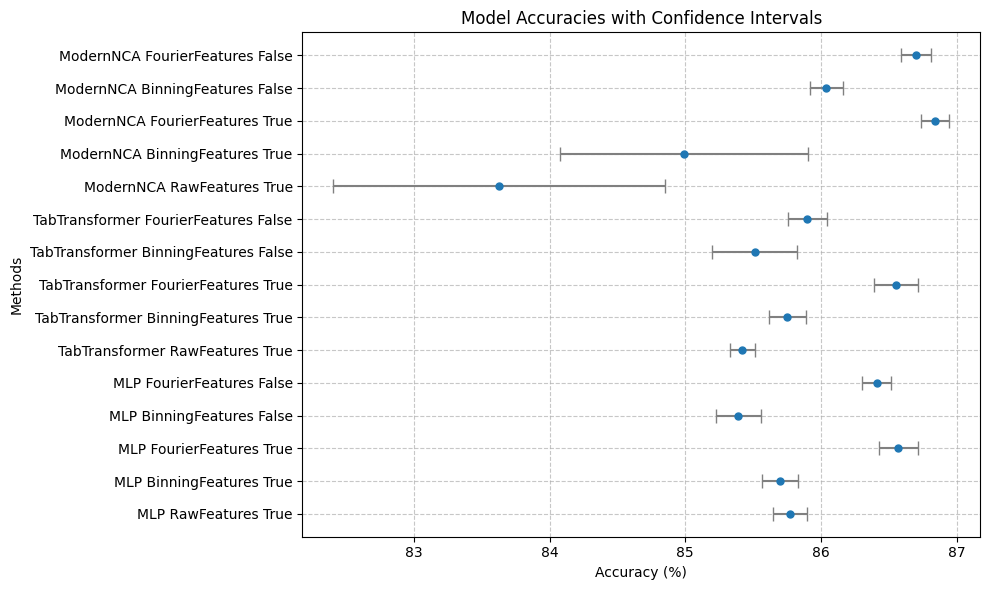

In [13]:
import math
import re
import ast
import pandas as pd
import os
import matplotlib.pyplot as plt
os.chdir('/home/mrsergazinov/TabLLM/feature_encoding_exp/')

# Initialize an empty list to store the results
results = []

# Replace 'your_file.txt' with the path to your text file
with open('results.txt', 'r') as f:
    lines = f.readlines()

# Variables to hold current parameters
current_params = None

# Loop through the lines
for line in lines:
    line = line.strip()
    if line.startswith('Parameters:'):
        # Extract the parameters
        params_str = line[len('Parameters: '):]
        # Safely evaluate the string to a dictionary
        params = ast.literal_eval(params_str)
        current_params = params
    elif line.startswith('Overall Average Accuracy over'):
        # Extract the mean and standard deviation
        match = re.search(r'Overall Average Accuracy over \d+ runs: ([\d\.]+)% ± ([\d\.]+)%', line)
        if match and current_params is not None:
            mean_accuracy = float(match.group(1))
            std_accuracy = float(match.group(2))
            # Combine parameters and accuracies into a single dictionary
            result = {
                'model_name': current_params.get('model_name'),
                'num_encoder': current_params.get('num_encoder'),
                'num_encoder_trainable': current_params.get('num_encoder_trainable'),
                'Average Accuracy (%)': mean_accuracy,
                'Std Dev (%)': std_accuracy / math.sqrt(10),
            }
            results.append(result)
            current_params = None  # Reset for the next block

# Create a DataFrame from the results
df = pd.DataFrame(results)

df['num_encoder'] = df['num_encoder'].fillna('RawFeatures')
df['num_encoder_trainable'] = df['num_encoder_trainable'].astype(str)
df['Method'] = (df['model_name'] + ' ' + df['num_encoder'] + ' ' + df['num_encoder_trainable']).astype(str)
plt.figure(figsize=(10, 6))
plt.errorbar(
    df['Average Accuracy (%)'],
    df['Method'],
    xerr=df['Std Dev (%)'],
    fmt='o',
    ecolor='gray',
    capsize=5,
    markersize=5,
    linestyle='None'
)
plt.xlabel('Accuracy (%)')
plt.ylabel('Methods')
plt.title('Model Accuracies with Confidence Intervals')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
